# Signal Energy

Signal energy could be think as "signal strength". Mathematically, the autocorrelation of a signal could be interpreted as the strength of similarity of the signal in a manner consistent with the way we measure signal energy.

So, signal energy could be calculate as:

$E_x=\int_{-\infty}^{\infty} |x(t)|^2 \,dt = \frac{1}{2\pi} \int_{-\infty}^{\infty} |X(\omega)|^2 \,d\omega = \int_{-\infty}^{\infty} |X(2\pi f)|^2 \,df$ 

(aka. **Parseval's theorem** for the Fourier Transform)

This allows us to determine the signal energy from either the time-domain $x(t)$ or the frequency-domain $X(\omega)$ of the signal

If we consider the small band of frequencies $\Delta \omega$ ($\Delta \omega \rightarrow 0$) located at $\omega = k \Delta \omega$, we could calculate the energy $\Delta E_x$ as:

$\Delta E_x = \frac{1}{2\pi} |X(k\Delta \omega)|^2 \Delta \omega = |X(k\Delta\omega)|^2 \Delta f$

![](figures/energy-espectral-density.jpg)

$|X(\omega)|^2 \Delta f$ represents the energy contibuted by the components in a band of $\Delta f$ Hz.

Therefore, $|X(\omega)|^2$ is the **energy spectral density** (per unit bandwidth in Hz)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.fft import fft
from scipy.signal import welch

plt.style.use('dark_background')

/home/lsym/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


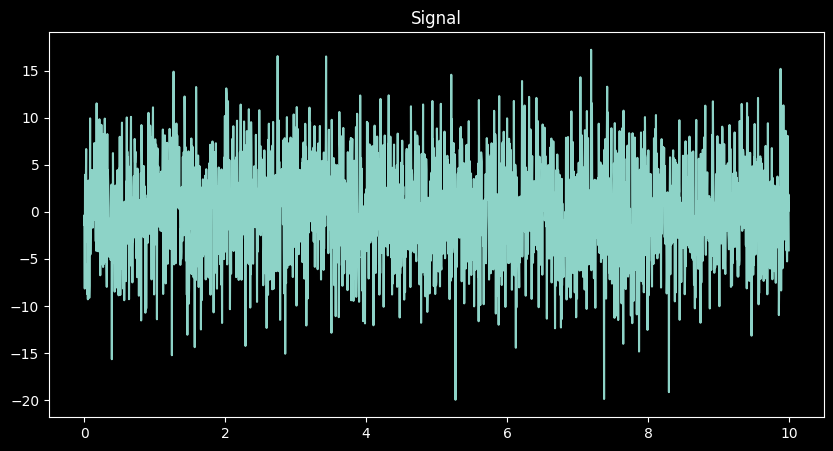

In [3]:
fs = 250
L = 50
t = np.linspace(0,L,fs*L)
sig = np.sin(2*np.pi*t) + np.sin(10*2*np.pi*t) + 5*np.random.normal(0,1,fs*L)

plt.figure(figsize=(10,5))
plt.title('Signal')
plt.plot(t[:10*fs],sig[:10*fs])
plt.show()

# Signal Power

We can extend the idea of energy spectral density to:

$P_x = \lim_{T \to \infty} \frac{1}{T} \int_{-T/2}^{T/2} |x(t)|^2 \,dt =  \lim_{T \to \infty} \frac{1}{T} \int_{-\infty}^{\infty} |x_T(t)|^2 \,dt = \lim_{T \to \infty} \frac{E_{x_T}}{T}$

where $x_T(t) = x(t) \Pi(\frac{t}{T})$

So:

$P_x = \lim_{T \to \infty} \frac{1}{2\pi} \int_{-\infty}^{\infty} \frac{|X_T(\omega)|^2}{T} \,d\omega = \frac{1}{2\pi} \int_{-\infty}^{\infty} S_x(\omega) \,d\omega$

where $S_x(\omega)$ is the **power spectral density** (PSD) of $x(t)$ and it is defined by:

$S_x(\omega) = \lim_{T \to \infty} \frac{|X_T(\omega)|^2}{T}$

Unlike the Fourier, PSD does not contain phase information so it is not invertible (so it is not possible to reconstruct the signal from the PSD). However, PSD has a wider range of applicability and can be defined for signals that becomes from random processes (biosignals)

## Power Spectral Density

### Spectral Stimation de PSD

*Aim*: Find an stimator $\hat{S_x}$ from N timepoints of a signal $x(t)$ that is stationary in wide sense

There are 2 kinds of stimators:

1. **No-parametric**: The main is to reduce the variance of the periodogram but lower the frequency resolution

a)*Periodogram:* Modulus squared of the Discrete Time Fourier Transform


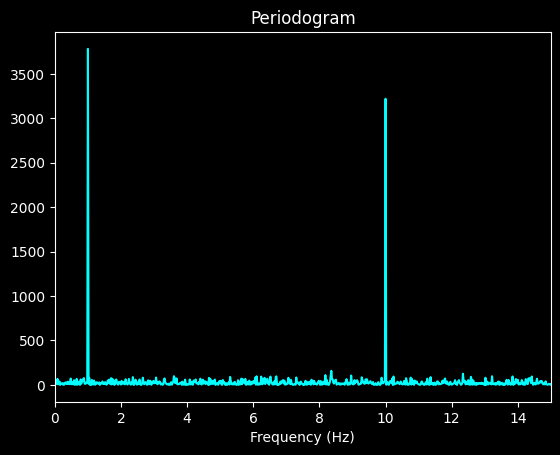

In [4]:
TFsig = fft(sig)
periodogram = np.abs(TFsig)**2 / len(TFsig)
f_p = np.linspace(0,fs//2,len(TFsig)//2)

plt.figure()
plt.plot(f_p, periodogram[:len(periodogram)//2], color='cyan')
plt.title('Periodogram')
plt.xlim(0,15)
plt.xlabel('Frequency (Hz)')
plt.show()

b) *Correlogram:* Discrete Time Fourier Transform of the autocorrelation stimator

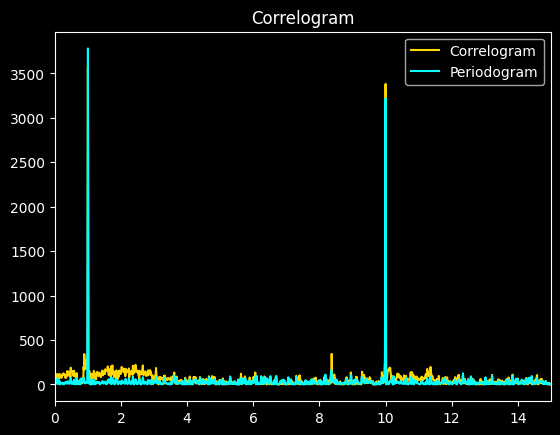

In [5]:
conv = np.convolve(sig,sig[::-1])
L = np.arange(-len(sig)+1,len(sig))
Rx = np.ndarray(shape=len(L), dtype=float)

# Unbiased correlation
for i in L:
    Rx[i] = conv[i]/(len(sig)-np.abs(L[i]))

Sx = np.abs(fft(Rx))/2
f_Sx = np.linspace(0,fs/2,len(Sx)//2)
plt.figure()
plt.plot(f_Sx,Sx[:len(Sx)//2],label='Correlogram', color='gold')
plt.plot(f_p, periodogram[:len(periodogram)//2], label='Periodogram', color='cyan')
plt.legend()
plt.xlim(0,15)
plt.title('Correlogram')
plt.show()

c) *Barlett Method:* Divide the signal in K parts and calculate the periodogram of each, the resulting stimator is the mean of them

50


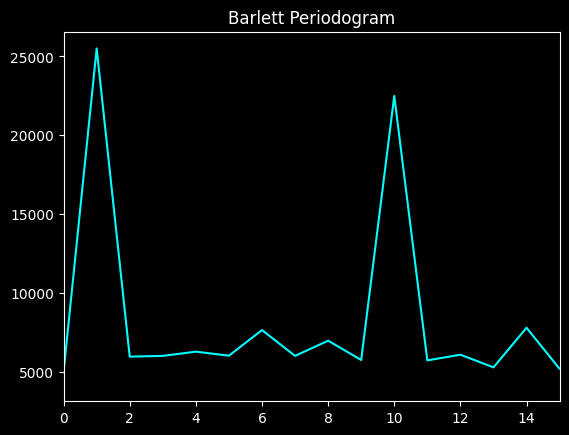

In [6]:
def barlett_periodogram(sig,L):
    n_segments = len(sig)//L
    print(n_segments)
    periodogram = np.zeros(L)
    for i in range(n_segments):
        segment=sig[i*L:(i+1)*L]
        periodogram += np.abs(fft(segment))**2
    periodogram = periodogram/n_segments
    return periodogram

plt.figure()
plt.plot(barlett_periodogram(sig,250), color='cyan')
plt.title('Barlett Periodogram')
plt.xlim(0,15)
plt.show()

d) *Welch Method:* Dicide the signal in K parts of length L that are overlapped, the resulting stimator is the mean of them

> See [Windowing.ipynb](Windowing.ipynb) for more information

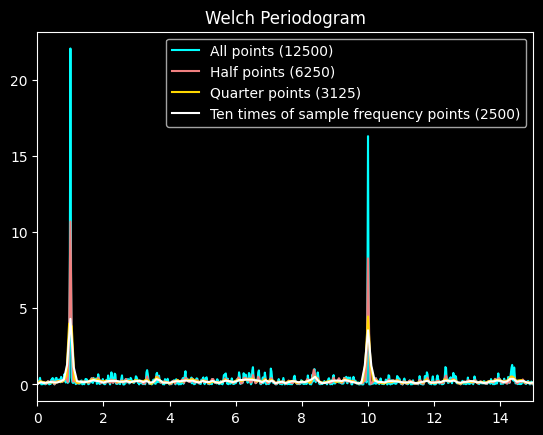

In [7]:
f_1, we_1 = welch(sig, fs=fs, nperseg=len(sig))
f_2, we_2 = welch(sig, fs=fs, nperseg=len(sig)//2)
f_3, we_3 = welch(sig, fs=fs, nperseg=len(sig)//4)
f_4, we_4 = welch(sig, fs=fs, nperseg=10*fs)

plt.figure()
plt.plot(f_1, we_1, color='cyan', label=f'All points ({len(sig)})')
plt.plot(f_2, we_2, color='lightcoral', label=f'Half points ({len(sig)//2})')
plt.plot(f_3, we_3, color='gold',label=f'Quarter points ({len(sig)//4})')
plt.plot(f_4, we_4, color='white',label=f'Ten times of sample frequency points ({10*fs})')
plt.title('Welch Periodogram')
plt.xlim(0,15)
plt.legend()
plt.show()

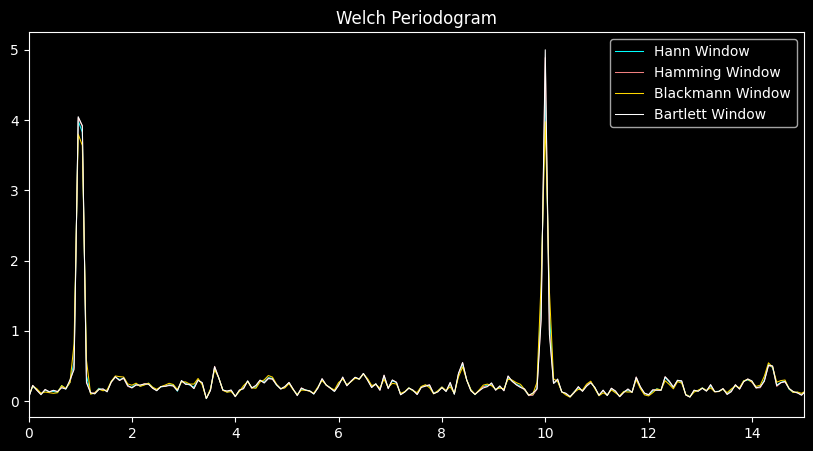

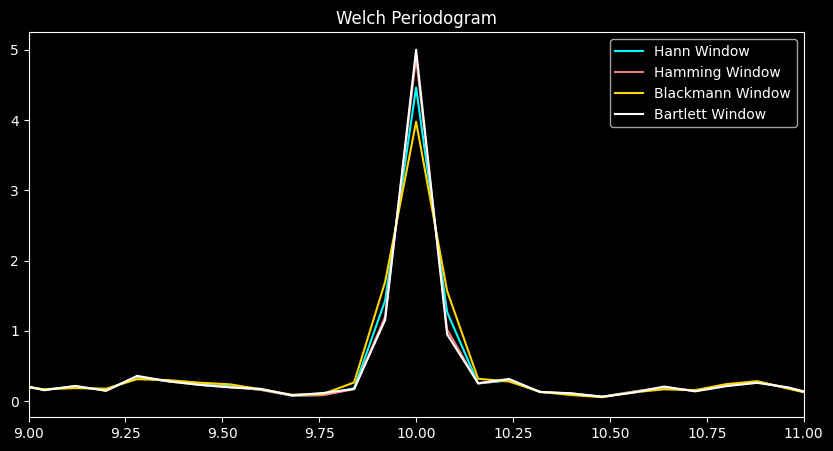

In [8]:
f_1, we_1 = welch(sig, fs=fs, nperseg=len(sig)//4, window='hann')
f_2, we_2 = welch(sig, fs=fs, nperseg=len(sig)//4, window='hamming')
f_3, we_3 = welch(sig, fs=fs, nperseg=len(sig)//4, window='blackman')
f_4, we_4 = welch(sig, fs=fs, nperseg=len(sig)//4, window='bartlett')


plt.figure(figsize=(10,5))
plt.plot(f_1, we_1, color='cyan', label=f'Hann Window',linewidth=0.75)
plt.plot(f_2, we_2, color='lightcoral', label=f'Hamming Window',linewidth=0.75)
plt.plot(f_3, we_3, color='gold',label=f'Blackmann Window',linewidth=0.75)
plt.plot(f_4, we_4, color='white',label=f'Bartlett Window', linewidth=0.75)
plt.title('Welch Periodogram')
plt.xlim(0,15)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(f_1, we_1, color='cyan', label=f'Hann Window')
plt.plot(f_2, we_2, color='lightcoral', label=f'Hamming Window')
plt.plot(f_3, we_3, color='gold',label=f'Blackmann Window')
plt.plot(f_4, we_4, color='white',label=f'Bartlett Window')
plt.title('Welch Periodogram')
plt.xlim(9,11)
plt.legend()
plt.show()

<span style="color:#00FF80">**Difference between Hann and Hamming**</span>

<span style="color:#00FF80">The differences are a few.</span>

<span style="color:#00FF80">Hamming window is 92% Hann window and 8% rectangular in order to reduce the height of the maximum side lobe.</span>

<span style="color:#00FF80">Hann window is a complementary window, that is the latter half of the window of one frame adds to the first half of the following frame to 1. For analysis, the property of being complementary is not important, but for synthesis or reconstruction is salient.</span>



2. **Parametric:** Express the system as a differential equation $y{n} + \sum_{i=1}^{K} a_i y[n-i] = \sum_{j=0}^{L} x[n-j]$
    * *AR processes:* $a_i = 0 \rightarrow y[n] = \sum_{j=0}^{L} b_k x[n-j]$
    * *MA processes:* $b_j = 0 \rightarrow y[n] + \sum_{i=1}^{K} a_i y[n-i] = x[n]$

# About bandpower of interest of the signal

In [9]:
import mne
from  scipy import integrate

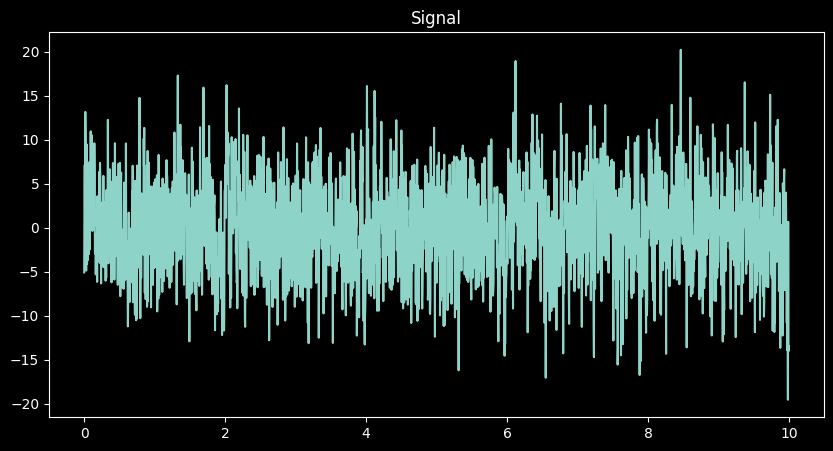

In [10]:
fs = 250
L = 30*fs
t = np.linspace(0,L,fs*L) 
# delta and 
sig = 5*np.random.normal(0,1,fs*L) + np.sin(2*np.pi*t) + np.sin(2.5*2*np.pi*t) + np.sin(3*2*np.pi*t) + np.sin(9*2*np.pi*t) + np.sin(9.5*2*np.pi*t) + np.sin(10*2*np.pi*t) + np.sin(10.5*2*np.pi*t) + np.sin(11*2*np.pi*t) + np.sin(12*2*np.pi*t)

plt.figure(figsize=(10,5))
plt.title('Signal')
plt.plot(t[:10*fs],sig[:10*fs])
plt.show()

## Welch

Effective window size : 1.000 (s)


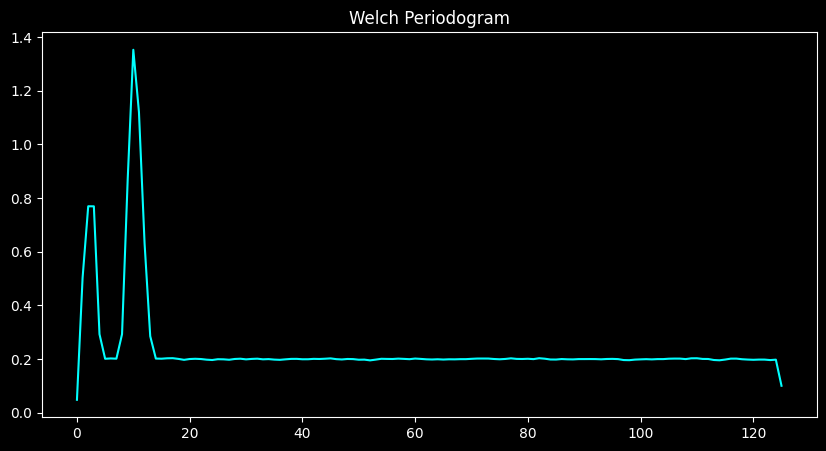

In [12]:
nperseg=int(fs)
nfft = nperseg
noverlap=int(nperseg/2)
psd_all, freq_all = mne.time_frequency.psd_array_welch(sig, 
                                                sfreq=fs, 
                                                n_fft=nfft, 
                                                n_per_seg=nperseg, 
                                                window='hann',
                                                n_overlap=noverlap,)

plt.figure(figsize=(10,5))
plt.plot(freq_all, psd_all, 'cyan')
plt.title('Welch Periodogram')
plt.show()

In [13]:
def set_freqs(rythm):
    if rythm == 'band1':
        return [0.5, 1]
    elif rythm == 'band2':
        return [1, 4]
    elif rythm == 'band3':
        return [4, 8]
    elif rythm == 'band4':
        return [8, 13]
    elif rythm == 'band5':
        return [15, 30]
    elif rythm == 'band6':
        return [30, 60]

In [15]:
nperseg=int(fs)
nfft = nperseg
noverlap=int(nperseg/2)
dic = {}
for r in ['band1', 'band2', 'band3', 'band4', 'band5', 'band6']:
    freqs = set_freqs(r)

    psd, freq = mne.time_frequency.psd_array_welch(sig, 
                                                    sfreq=fs, 
                                                    n_fft=nfft, 
                                                    n_per_seg=nperseg, 
                                                    window='hann',
                                                    n_overlap=noverlap,
                                                    fmin=freqs[0], fmax=freqs[1])
    auc = integrate.simpson(psd, freq)/(freqs[1]-freqs[0])

    dic[r] = auc

print(dic)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
{'band1': 0.0, 'band2': 0.6735439479997555, 'band3': 0.21676687767759364, 'band4': 0.861369671404411, 'band5': 0.19995333127808618, 'band6': 0.199777625590421}


Order bandpower in decrescending order:

In [16]:
dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

{'band4': 0.861369671404411,
 'band2': 0.6735439479997555,
 'band3': 0.21676687767759364,
 'band5': 0.19995333127808618,
 'band6': 0.199777625590421,
 'band1': 0.0}

**Relative power**

In [20]:
nperseg=int(fs)
nfft = nperseg
noverlap=int(nperseg/2)

total_psd, total_freq = mne.time_frequency.psd_array_welch(sig, 
                                                sfreq=fs, 
                                                n_fft=nfft, 
                                                n_per_seg=nperseg, 
                                                window='hann',
                                                n_overlap=noverlap)

total_auc = integrate.simpson(total_psd, total_freq)

dic = {}

for r in ['band1', 'band2', 'band3', 'band4', 'band5', 'band6']:
    freqs = set_freqs(r)

    psd, freq = mne.time_frequency.psd_array_welch(sig, 
                                                    sfreq=fs, 
                                                    n_fft=nfft, 
                                                    n_per_seg=nperseg, 
                                                    window='hann',
                                                    n_overlap=noverlap,
                                                    fmin=freqs[0], fmax=freqs[1])
    auc = integrate.simpson(psd, freq)/(freqs[1]-freqs[0])/total_auc

    dic[r] = auc

print(dic)

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
{'band1': 0.0, 'band2': 0.022568303880402523, 'band3': 0.007263164907296816, 'band4': 0.028861743254241626, 'band5': 0.00669979673276536, 'band6': 0.0066939093970324525}


In [21]:
dict(sorted(dic.items(), key=lambda item: item[1], reverse=True))

{'band4': 0.028861743254241626,
 'band2': 0.022568303880402523,
 'band3': 0.007263164907296816,
 'band5': 0.00669979673276536,
 'band6': 0.0066939093970324525,
 'band1': 0.0}

## Multitaper